In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import copy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class EarlyStopping():
  def __init__(self, patience=5, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
    self.best_state_dict = None

  def __call__(self, train_loss, model):
    if self.best_loss is None or train_loss < self.best_loss:
      self.best_loss = train_loss
      self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
      self.counter = 0
      # if self.verbose:
      #   print(f"Training loss improved to {train_loss:.4f}. Saving model.")
    else:
      self.counter += 1
      # if self.verbose:
      #   print(f"No improvement in training loss for {self.counter} epochs.")
      if self.counter >= self.patience:
        if self.verbose:
          print("Early stopping triggered.")
        self.early_stop = True

  def restore_best_weights(self, model):
    if self.best_state_dict is not None:
      model.load_state_dict(self.best_state_dict)

class Encoder(nn.Module):
  def __init__(self, dims, drp_p):
    super(Encoder, self).__init__()
    self.fc = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-2)])
    self.feature = nn.Linear(dims[-2], dims[-1])
    self.drp = nn.ModuleList([nn.Dropout(p=drp_p[i]) for i in range(len(drp_p))])
    # for layer in self.fc:
    #     nn.init.normal_(layer.weight, mean=0.0, std=0.001)
    # nn.init.normal_(self.feature.weight, mean=0.0, std=0.001)

  def forward(self, x):
    for fc, drp in zip(self.fc, self.drp):
      x = drp(x)
      x = F.relu(fc(x))
    x = self.feature(x)
    return x

class Decoder(nn.Module):
  def __init__(self, dims, drp_p):
    super(Decoder, self).__init__()
    self.fc = nn.ModuleList([nn.Linear(dims[i], dims[i-1]) for i in range(len(dims)-1, 1, -1)])
    self.rec = nn.Linear(dims[1], dims[0])
    self.drp = nn.ModuleList([nn.Dropout(p=drp_p[i]) for i in range(len(drp_p)-1, -1, -1)])
    # for layer in self.fc:
    #     nn.init.normal_(layer.weight, mean=0.0, std=0.001)
    # nn.init.normal_(self.rec.weight, mean=0.0, std=0.001)

  def forward(self, x):
    for fc, drp in zip(self.fc, self.drp):
      x = drp(x)
      x = F.relu(fc(x))
    x = self.rec(x)
    return x

class AutoEncoder(nn.Module):
  def __init__(self, dims, drp_p):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder(dims, drp_p)
    self.decoder = Decoder(dims, drp_p)

  def forward(self, x):
    z = self.encoder(x)
    x_recon = self.decoder(z)
    return z, x_recon

class Clustering(nn.Module):
  def __init__(self, centroid, alpha):
    super(Clustering, self).__init__()
    self.alpha = alpha
    self.centroid = nn.Parameter(centroid)

  def forward(self, z):
    diff = z.unsqueeze(1) - self.centroid.unsqueeze(0)
    dist_sq = torch.sum(diff ** 2, dim=2)
    degree = -(self.alpha + 1) / 2
    sim = (1 + dist_sq / self.alpha) ** degree
    q = sim / torch.sum(sim, dim=1, keepdim=True)
    f = torch.sum(q, dim=0,)
    p = (q ** 2 / f) / torch.sum(q ** 2 / f, dim=1, keepdim=True)
    return q, p

class LossFunction(nn.Module):
  def __init__(self, loss="least_square"):
    super(LossFunction, self).__init__()
    self.loss = loss

  def forward(self, y_pred=None, y_true=None, q=None, p=None):
    if self.loss == "least_square":
      loss = self.leastsquare(y_pred, y_true)
    elif self.loss == "kl_divergence":
      loss = self.kld(q, p)
    else:
      raise ValueError("Loss function not found")
    return loss

  def leastsquare(self, y_pred, y_true):
    loss = torch.mean((y_pred - y_true) ** 2)
    return loss

  def kld(self, q, p):
    loss = torch.sum(p * torch.log(p / q), dim=1)
    loss = torch.sum(loss)
    return loss

class DECModels(nn.Module):
  def __init__(self, n_clusters, alpha, dims, drp_p):
    super(DECModels, self).__init__()
    self.n_clusters = n_clusters
    self.alpha = alpha
    self.dims = dims
    self.autoencoder = AutoEncoder(dims, drp_p)
    self.centroids = torch.tensor(np.random.rand(n_clusters, dims[-1]), dtype=torch.float32)
    self.clustering = Clustering(self.centroids, self.alpha)
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.autoencoder = self.autoencoder.to(self.device)
    self.clustering = self.clustering.to(self.device)

  def fit(self, x, epochs_autoencoder, epochs_clustering, epochs_one_layer, batch_size, lr_en, lr_cl, optim,
          training_encoder=True, training_clustering=True, training_one_layer=True,use_Kmeans=True,
          earlystopping_en=False, earlystopping_cl=True, patience=10, tol=0.1):
    loss_fn_rec = LossFunction(loss="least_square")
    loss_fn_cluster = LossFunction(loss="kl_divergence")
    x_ = x
    x = DataLoader(x, batch_size=batch_size, shuffle=True)

    if training_encoder:
      if training_one_layer:
        def train_one_layer_autoencoder(encoder_layer, decoder_layer, x, layer):
          try:
            optimizer = optim(list(encoder_layer.parameters()) + list(decoder_layer.parameters()), lr=lr_en, momentum=0.9)
          except:
            optimizer = optim(list(encoder_layer.parameters()) + list(decoder_layer.parameters()), lr=lr_en)
          scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(x)*3, gamma=0.95)
          if earlystopping_en:
            early_stopping1 = EarlyStopping(patience, verbose=True)
          desc = f"Training AutoEncoder Layer {layer}"
          with tqdm(range(epochs_one_layer), desc=desc, unit="epoch", ncols=100) as t:
            for epoch in t:
              total_loss = count = 0
              for data in x:
                optimizer.zero_grad()
                try:
                  data = data.to(self.device)
                except:
                  data = data[0].to(self.device)
                recon = decoder_layer(encoder_layer(data))
                loss = loss_fn_rec(recon, data)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
              t.set_postfix(loss=total_loss/count)
              scheduler.step()
              if earlystopping_en:
                early_stopping1(total_loss/count, nn.Sequential(encoder_layer, decoder_layer))
                if early_stopping1.early_stop:
                  print(f"Stop training at epoch {epoch}")
                  early_stopping1.restore_best_weights(nn.Sequential(encoder_layer, decoder_layer))
                  break
          return encoder_layer, decoder_layer

        current_input = x
        for i in range(len(self.dims)-1):
          if i == len(self.dims)-2:
            enc_layer = nn.Sequential(self.autoencoder.encoder.drp[i], self.autoencoder.encoder.feature)
          else:
            enc_layer = nn.Sequential(self.autoencoder.encoder.drp[i], self.autoencoder.encoder.fc[i], nn.ReLU())
          if i == 0:
            dec_layer = nn.Sequential(self.autoencoder.decoder.drp[-(i+1)], self.autoencoder.decoder.rec)
          else:
            dec_layer = nn.Sequential(self.autoencoder.decoder.drp[-(i+1)], self.autoencoder.decoder.fc[-(i)], nn.ReLU())
          train_one_layer_autoencoder(enc_layer, dec_layer, current_input, i+1)
          encoded_outputs = []
          with torch.no_grad():
            for batch in current_input:
              try:
                batch = batch.to(self.device)
              except:
                batch = batch[0].to(self.device)
              encoded_outputs.append(enc_layer(batch).cpu())
          current_input = DataLoader(TensorDataset(torch.cat(encoded_outputs, dim=0)), batch_size=batch_size, shuffle=True)

      def training_one_epochs_autoencoder(x, optimizer):
        total_loss = count = 0
        for data in x:
          optimizer.zero_grad()
          data = data.to(self.device)
          _, recon = self.autoencoder(data)
          loss = loss_fn_rec(recon, data)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          count += 1
        return total_loss/count

      def training_autoencoder(x):
        self.autoencoder.train()
        if earlystopping_en:
          early_stopping2 = EarlyStopping(patience, verbose=True)
        loss_his_ae = []
        try:
          optimizer = optim(self.autoencoder.parameters(), lr=lr_en, momentum=0.9)
        except:
          optimizer = optim(self.autoencoder.parameters(), lr=lr_en)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(x)*3, gamma=0.95)
        with tqdm(range(epochs_autoencoder), desc="Training AutoEncoder", unit="epoch", ncols=100) as t:
          for epoch in t:
            loss = training_one_epochs_autoencoder(x, optimizer)
            loss_his_ae.append(loss)
            t.set_postfix(loss=loss)
            if earlystopping_en:
              early_stopping2(loss, self.autoencoder)
              if early_stopping2.early_stop:
                print(f"Stop training at epoch {epoch}")
                early_stopping2.restore_best_weights(self.autoencoder)
                break
            scheduler.step()
        return loss_his_ae
      loss_his_ae = training_autoencoder(x)

    if training_clustering:
      self.encoder = copy.deepcopy(self.autoencoder.encoder)
      if use_Kmeans:
        self.autoencoder.eval()
        with torch.no_grad():
          latent_all = self.encoder(x_.to(self.device))
          latent_all_np = latent_all.cpu().numpy()
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20, init="k-means++")
        kmeans.fit(latent_all_np)
        centroids = kmeans.cluster_centers_
        centroids = torch.tensor(centroids, dtype=torch.float32, device=self.device)
      else:
        encoded_x = self.encoder(x_.to(self.device))
        random_indices = np.random.choice(encoded_x.shape[0], size=self.n_clusters, replace=False)
        centroids = encoded_x[random_indices]

      self.centroids = centroids
      self.clustering.centroid.data = centroids.detach().clone()
      self.autoencoder.train()
      self.clustering.train()
      x = DataLoader(TensorDataset(x_, torch.arange(len(x_))), batch_size=batch_size, shuffle=True)
      optimizer = optim(list(self.encoder.parameters()) + list(self.clustering.parameters()), lr=lr_cl)
      q_labels, _ = self.forward(x_)
      assign_prev = torch.argmax(q_labels, dim=1).cpu().numpy()
      change_rate_his = []
      sht = []
      with tqdm(range(epochs_clustering), desc="Training Clustering", unit="epoch", ncols=120) as t:
        for epoch in t:
          with torch.no_grad():
            q_all, p_all = self.clustering(self.encoder(x_.to(self.device)))
          for data, idx in x:
            optimizer.zero_grad()
            q, _ = self.clustering(self.encoder(data.to(self.device)))
            loss = loss_fn_cluster(q=q, p=p_all[idx])
            loss.backward()
            optimizer.step()
          q_, z_ = self.forward(x_)
          s_c = silhouette_score(z_.detach().cpu().numpy(), q_.argmax(dim=1).detach().cpu().numpy(), metric='euclidean')
          assign_curr = torch.argmax(q_, dim=1).cpu().numpy()
          change_rate = np.sum(assign_curr != assign_prev) / len(assign_curr) * 100
          change_rate_his.append(change_rate)
          sht.append(s_c)
          t.set_postfix(silhouette=s_c, change_rate=change_rate)
          if earlystopping_cl:
            if change_rate < tol:
              if epoch % 2 == 0:
                print(f"\nStop training at epoch {epoch}, change rate {change_rate}, silhouette score {s_c}")
              else:
                print(f"Stop training at epoch {epoch}, change rate {change_rate}, silhouette score {s_c}")
              break
            assign_prev = assign_curr

    if training_encoder and training_clustering:
      return {"AutoEncoder Loss":loss_his_ae, "Change Rate Cluster":change_rate_his, "Silhouette Score":sht}
    elif training_clustering:
      return {"Change Rate Cluster":change_rate_his, "Silhouette Score":sht}
    else:
      return {"AutoEncoder Loss":loss_his_ae}

  def forward(self, x):
    try:
      self.encoder.eval()
    except:
      self.encoder = copy.deepcopy(self.autoencoder.encoder)
      self.encoder.eval()
    self.clustering.eval()
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
    x = x.to(self.device)
    with torch.no_grad():
      z = self.encoder(x)
      q, p = self.clustering(z)
    return [q, z]

  def predict(self, x):
    q, z = self.forward(x)
    return [q, z]

In [8]:
import requests

url = 'https://raw.githubusercontent.com/Mfys212/dokumen/main/kaggle.json'
destination = '/content/kaggle.json'

response = requests.get(url)
if response.status_code == 200:
  with open(destination, 'wb') as file:
    file.write(response.content)
  print(f'Succes {destination}')
else:
  print(f'Failed: {response.status_code}')

Succes /content/kaggle.json


In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arjunbhasin2013/ccdata
!unzip /content/ccdata.zip

Dataset URL: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
License(s): CC0-1.0
  0% 0.00/340k [00:00<?, ?B/s]
100% 340k/340k [00:00<00:00, 960MB/s]
Archive:  /content/ccdata.zip
  inflating: CC GENERAL.csv          


In [10]:
import pandas as pd

df = pd.read_csv('/content/CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [11]:
from sklearn.preprocessing import MinMaxScaler

data_x = df.drop(['CUST_ID'], axis=1)
numeric_columns = data_x.columns.values.tolist()
scaler = MinMaxScaler(feature_range=(0, 1))
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.fillna(0, inplace=True)
data_x.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


In [12]:
x = torch.tensor(data_x.values, dtype=torch.float32)
x.shape

torch.Size([8950, 17])

In [13]:
for num_clusters in range(2,10):
  clusterer = KMeans(n_clusters=num_clusters, n_init=20, init="k-means++")
  preds = clusterer.fit_predict(x)
  score = silhouette_score(x, preds, metric='euclidean')
  print(f"n_clusters = {num_clusters}, kmeans silhouette score is {score})")

n_clusters = 2, kmeans silhouette score is 0.3867190480232239)
n_clusters = 3, kmeans silhouette score is 0.3723914325237274)
n_clusters = 4, kmeans silhouette score is 0.3215104937553406)
n_clusters = 5, kmeans silhouette score is 0.3191244900226593)
n_clusters = 6, kmeans silhouette score is 0.33423107862472534)
n_clusters = 7, kmeans silhouette score is 0.33778074383735657)
n_clusters = 8, kmeans silhouette score is 0.3154875934123993)
n_clusters = 9, kmeans silhouette score is 0.33435940742492676)


In [14]:
n_cluster = range(2, 10)
alpha = 1.0
dims = [x.shape[-1], 32, 32, 64, 10] # dimensi neural networks
drp_p = [0.1, 0.1, 0.1, 0.1] # dropout dengan panjang len(dims) - 1
batch_size = 128 # batch size
epochs_one_layer = 100 # jumlah epoch untuk training autoencoder perlayer
epochs_autoencoder = 200 # jumlah epoch untuk training autoencoder full end to end
epochs_clustering = 200 # jumlah epoch untuk training clustering (akan di berhentikan otomatis jika kurang dari tol% data yg berubah klasternya)
lr_en = 0.1 # learning rate untuk training outoencoder
lr_cl = 0.01 # learning rate untuk training clustering
optimizer = torch.optim.SGD # optimizer (dari pytorch)
training_one_layer = True # apakah training autoencoder perlayer
use_Kmeans = True # apakah menggunakan kmeans untuk mencari centorid awal
earlystopping_autoencoder = False # apakah menggunakan earlystopping pas training autoencoder
earlystopping_clustering = True # apakah menggunakan earlystopping (tol% data yg berubah klasternya)
tol = 0.1 # tol
patience = 15 # earlystopping setelah berapa epoch gak turun loss untuk autoencoder jika menggunakan earlystopping
training_encoder = True # apakah training autoencoder
training_clustering = False # apakah training clustering

history = {}
DEC = DECModels(n_cluster[0], alpha, dims, drp_p)
history["autoencoder"] = DEC.fit(x, epochs_autoencoder, epochs_clustering, epochs_one_layer, batch_size,
                                lr_en, lr_cl, optimizer, training_encoder, training_clustering, training_one_layer,
                                use_Kmeans, earlystopping_autoencoder, earlystopping_clustering, patience, tol)

training_encoder = False # apakah training autoencoder
training_clustering = True # apakah training clustering
sht, best_sht = [], 0
for n in n_cluster:
  print(f"\nclustering dengan n_cluster = {n}")
  DEC.n_clusters = n
  history[f"{n}_cluster"] = DEC.fit(x, epochs_autoencoder, epochs_clustering, epochs_one_layer, batch_size,
                                    lr_en, lr_cl, optimizer, training_encoder, training_clustering, training_one_layer,
                                    use_Kmeans, earlystopping_autoencoder, earlystopping_clustering, patience, tol)
  globals()[f"model_{n}_cluster"] = copy.deepcopy(DEC)
  q, z = DEC(x)
  s_c = silhouette_score(z.detach().cpu().numpy(), q.argmax(dim=1).detach().cpu().numpy(), metric='euclidean')
  sht.append(s_c)
  if s_c > best_sht:
    best_sht = s_c
    best_model = copy.deepcopy(DEC)
  print("-" * 150)

Training AutoEncoder: 100%|██████████████████████| 200/200 [00:25<00:00,  7.98epoch/s, loss=0.00828]



clustering dengan n_cluster = 2


Training Clustering:  10%|█▉                  | 19/200 [00:20<03:19,  1.10s/epoch, change_rate=0.0894, silhouette=0.959]


Stop training at epoch 19, change rate 0.0893854748603352, silhouette score 0.9592956900596619
------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 3


Training Clustering:  36%|███████▎            | 73/200 [01:07<01:56,  1.09epoch/s, change_rate=0.0559, silhouette=0.963]


Stop training at epoch 73, change rate 0.055865921787709494, silhouette score 0.9629003405570984
------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 4


Training Clustering: 100%|████████████████████| 200/200 [02:53<00:00,  1.15epoch/s, change_rate=0.402, silhouette=0.968]


------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 5


Training Clustering: 100%|██████████████████████| 200/200 [02:55<00:00,  1.14epoch/s, change_rate=3.31, silhouette=0.93]


------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 6


Training Clustering: 100%|████████████████████| 200/200 [02:55<00:00,  1.14epoch/s, change_rate=0.603, silhouette=0.938]


------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 7


Training Clustering: 100%|████████████████████| 200/200 [02:51<00:00,  1.17epoch/s, change_rate=0.883, silhouette=0.931]


------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 8


Training Clustering: 100%|█████████████████████| 200/200 [02:49<00:00,  1.18epoch/s, change_rate=1.16, silhouette=0.942]


------------------------------------------------------------------------------------------------------------------------------------------------------

clustering dengan n_cluster = 9


Training Clustering: 100%|█████████████████████| 200/200 [02:48<00:00,  1.19epoch/s, change_rate=18.5, silhouette=0.806]


------------------------------------------------------------------------------------------------------------------------------------------------------


In [15]:
best_sht

np.float32(0.9678776)

Text(0.5, 1.0, 'AutoEncoder Loss')

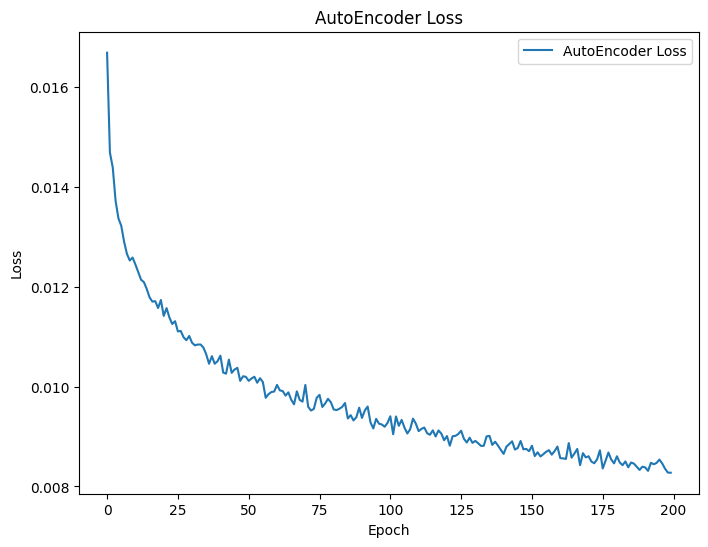

In [16]:
import matplotlib.pyplot as plt

epochs_range = range(len(history["autoencoder"]['AutoEncoder Loss']))
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, history["autoencoder"]['AutoEncoder Loss'], label='AutoEncoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('AutoEncoder Loss')

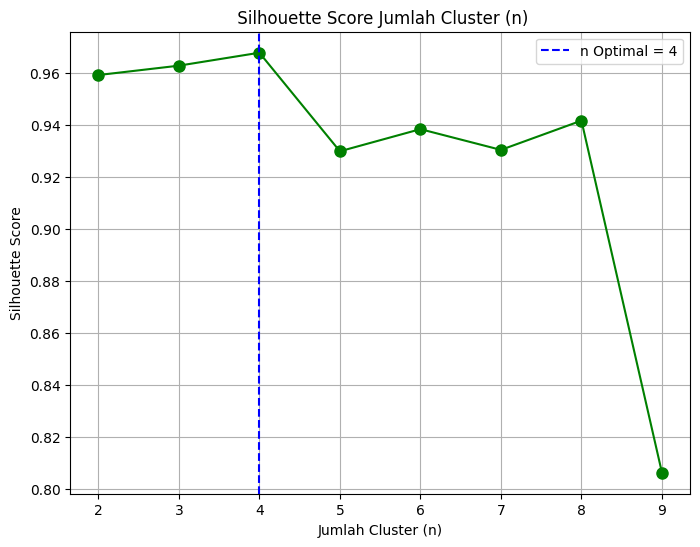

In [23]:
best_n = n_cluster[np.argmax(np.array(sht))]
plt.figure(figsize=(8, 6))
plt.plot(n_cluster, sht, 'go-', markersize=8)
plt.title(' Silhouette Score Jumlah Cluster (n)')
plt.xlabel('Jumlah Cluster (n)')
plt.ylabel('Silhouette Score')
plt.xticks(list(n_cluster))
plt.axvline(x=best_n, color='blue', linestyle='--', label=f'n Optimal = {best_n}')
plt.legend()
plt.grid(True)
plt.show()

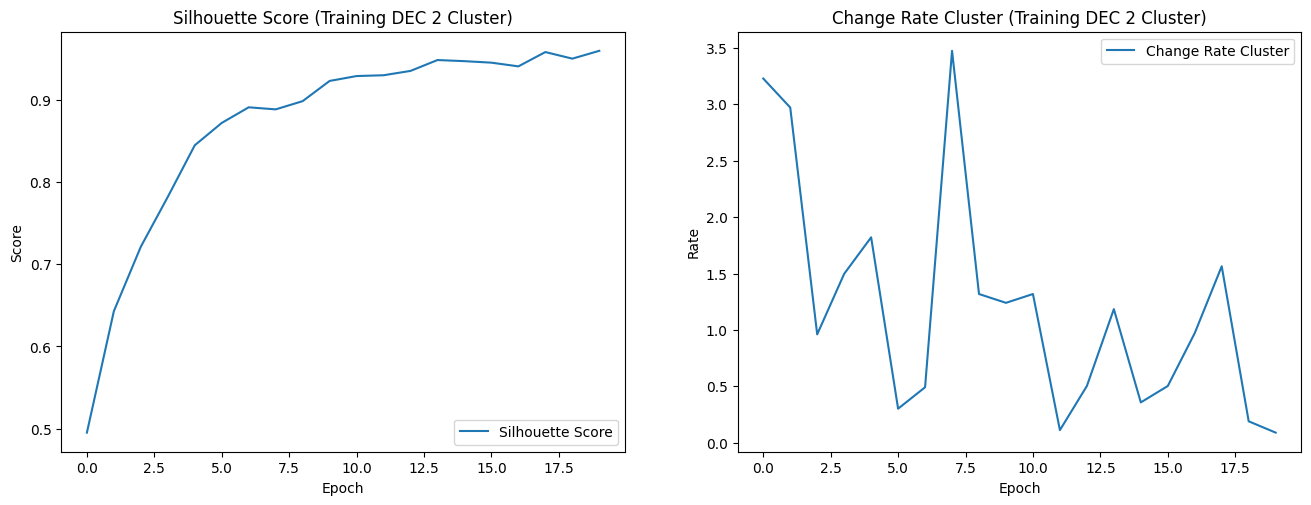

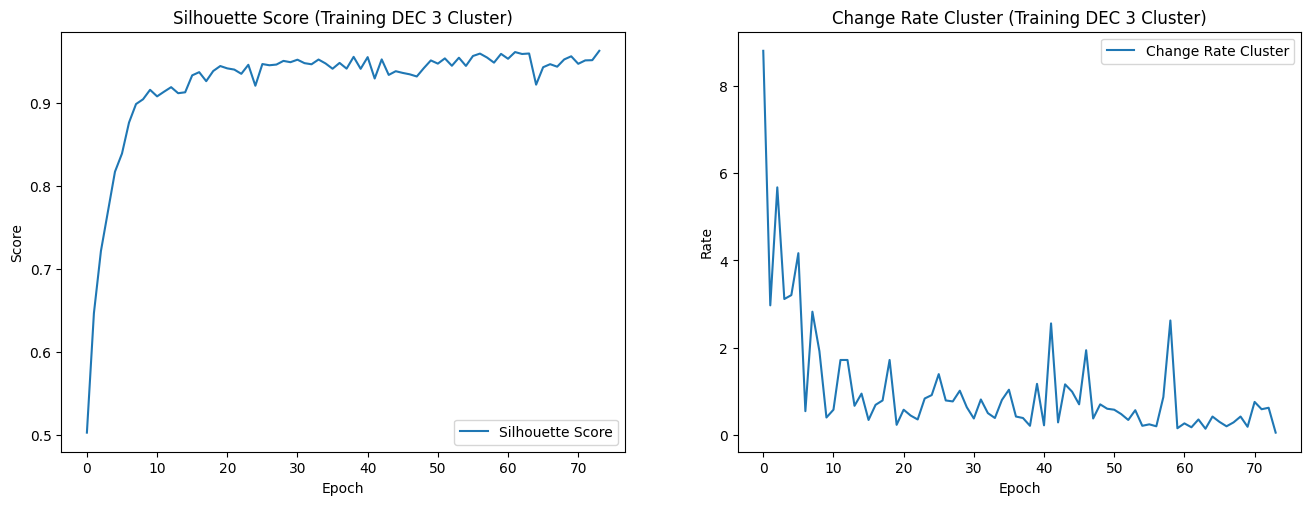

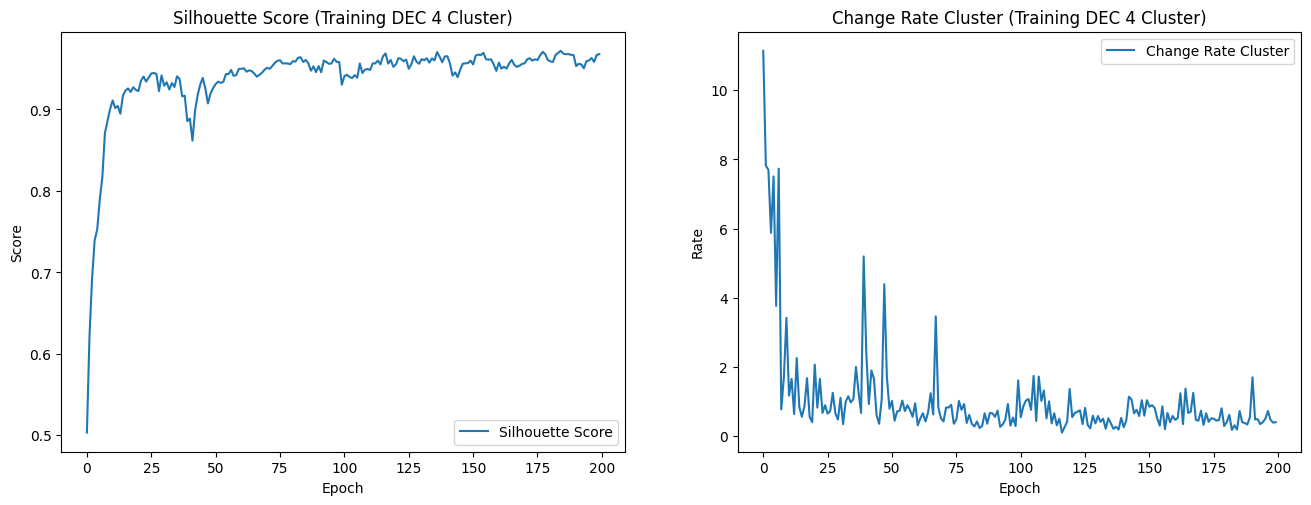

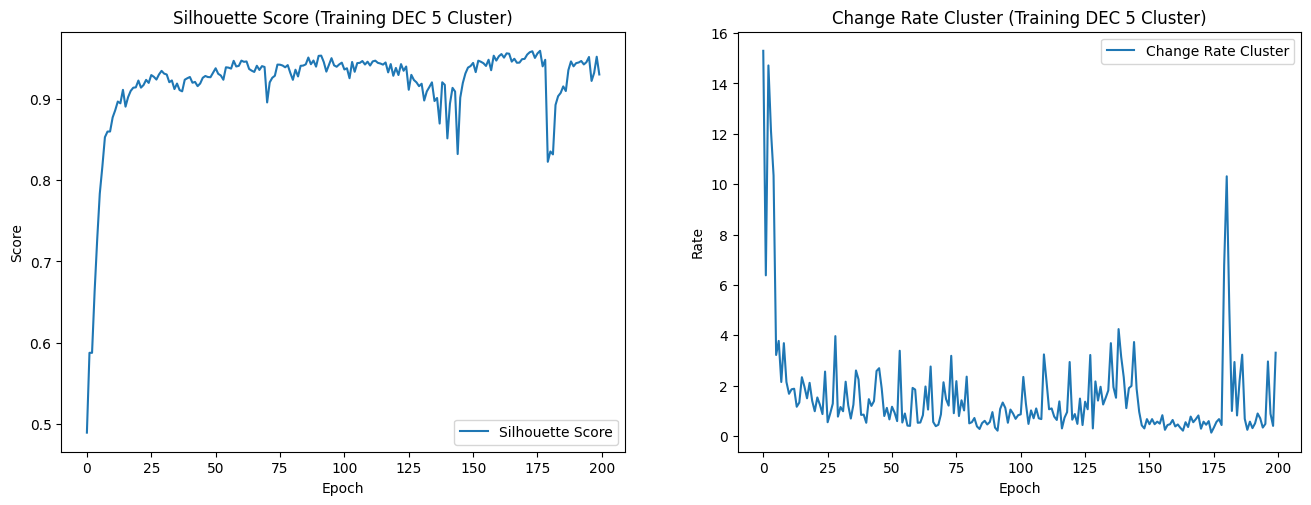

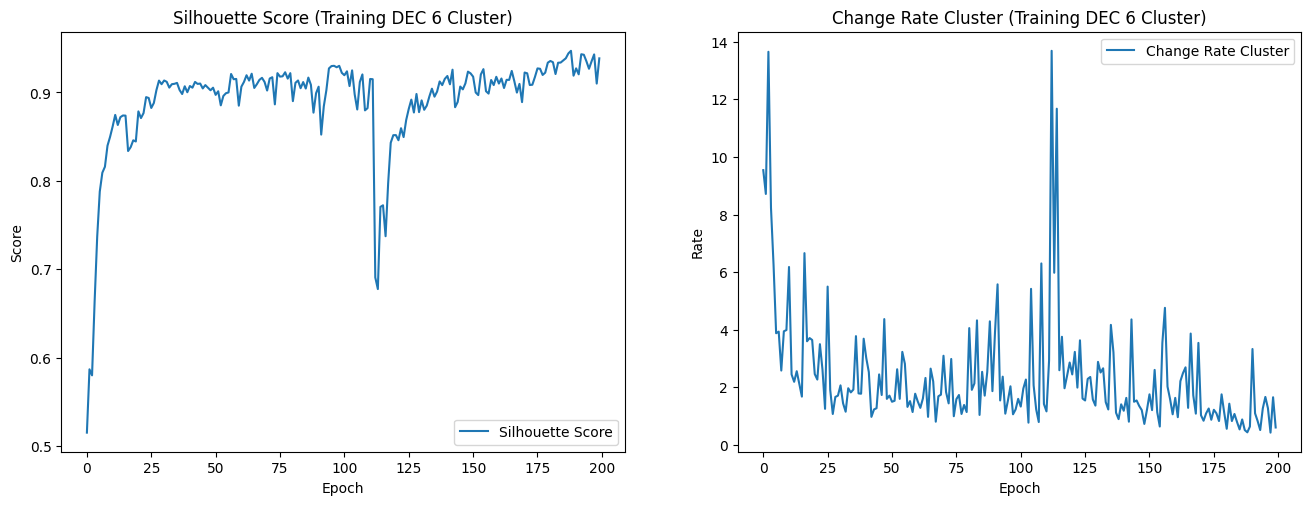

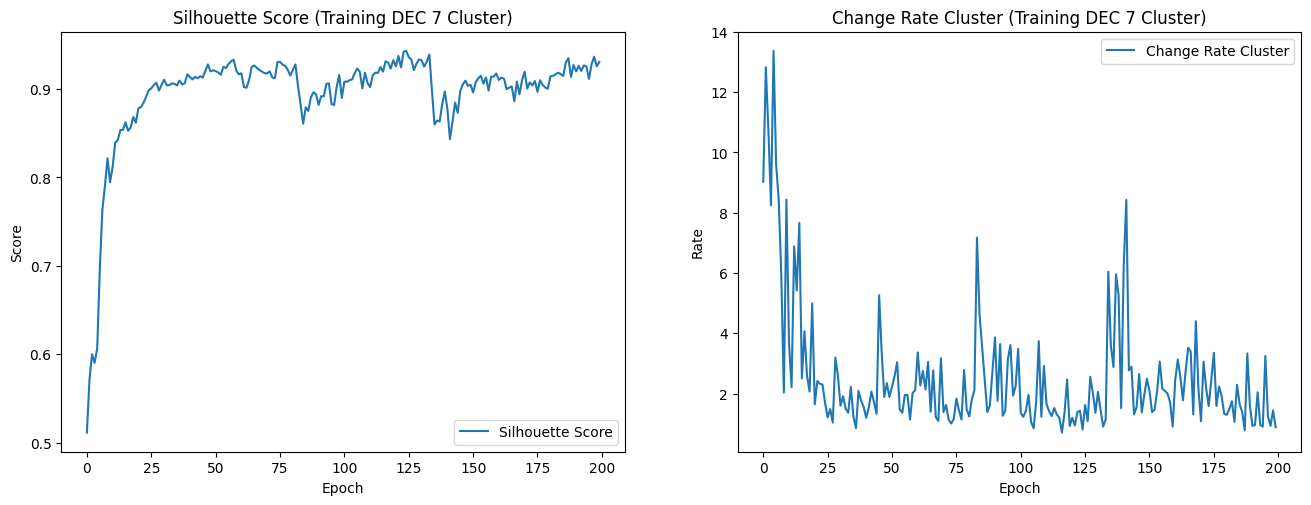

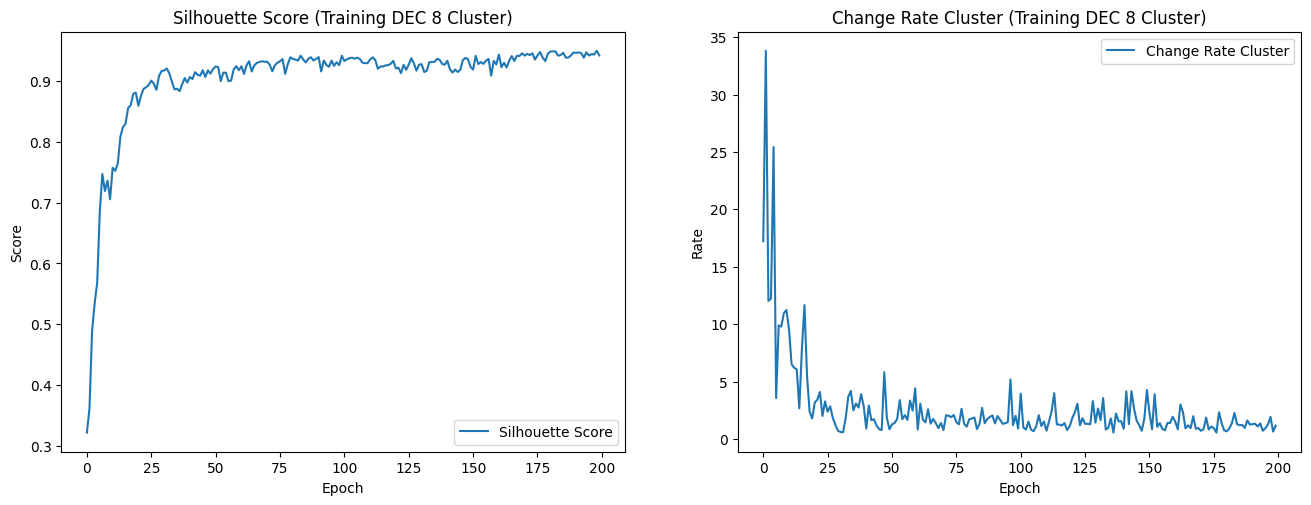

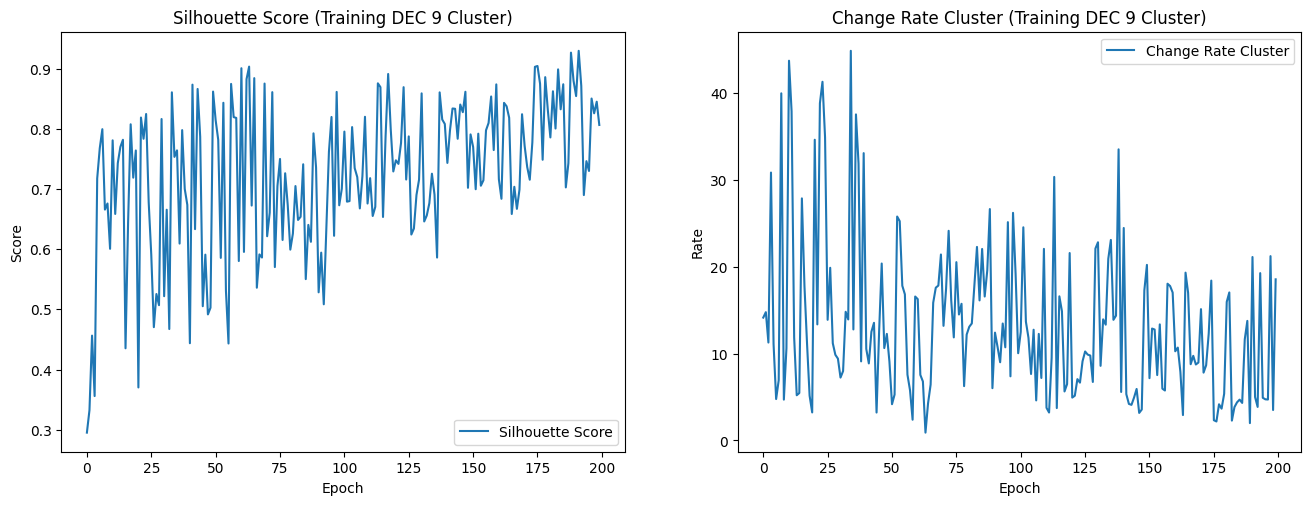

In [18]:
for n in n_cluster:
  epochs_range = range(len(history[f"{n}_cluster"]['Silhouette Score']))
  plt.figure(figsize=(16, 12))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, history[f"{n}_cluster"]['Silhouette Score'], label='Silhouette Score')
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.legend(loc='lower right')
  plt.title(f'Silhouette Score (Training DEC {n} Cluster)')

  epochs_range = range(len(history[f"{n}_cluster"]['Change Rate Cluster']))
  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, history[f"{n}_cluster"]['Change Rate Cluster'], label='Change Rate Cluster')
  plt.xlabel('Epoch')
  plt.ylabel('Rate')
  plt.legend(loc='upper right')
  plt.title(f'Change Rate Cluster (Training DEC {n} Cluster)')
  plt.show()

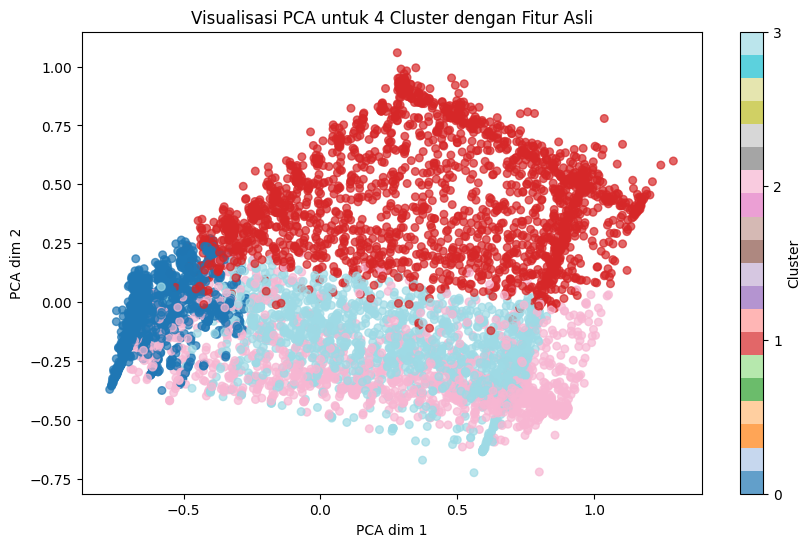

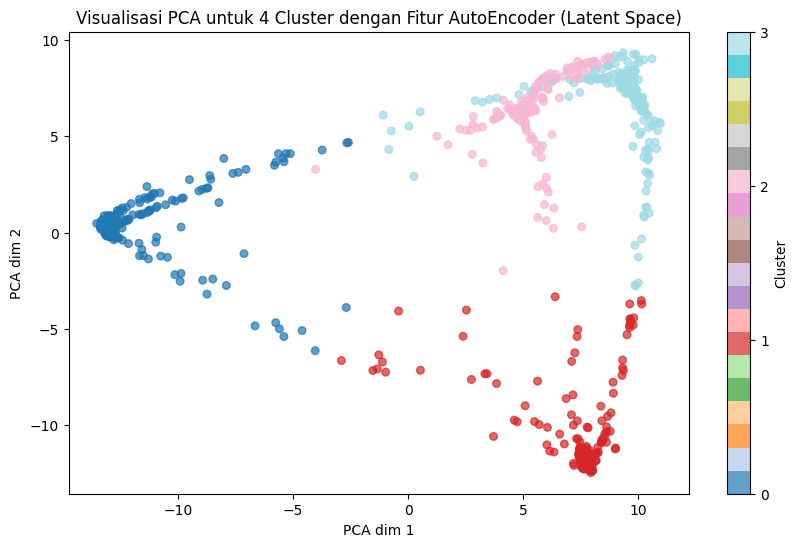

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

q, z = best_model(x) # q : vektor probalilitas data i masuk ke klaster j, z : latent space hasil encoder
labels = q.argmax(dim=1).detach().cpu().numpy()
z_2d = PCA(n_components=2).fit_transform(z.detach().cpu().numpy())
x_2d = PCA(n_components=2).fit_transform(x)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
plt.title(f"Visualisasi PCA untuk {len(np.unique(labels))} Cluster dengan Fitur Asli")
plt.xlabel("PCA dim 1")
plt.ylabel("PCA dim 2")
plt.show()
print("")
plt.figure(figsize=(10, 6))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
plt.title(f"Visualisasi PCA untuk {len(np.unique(labels))} Cluster dengan Fitur AutoEncoder (Latent Space)")
plt.xlabel("PCA dim 1")
plt.ylabel("PCA dim 2")
plt.show()

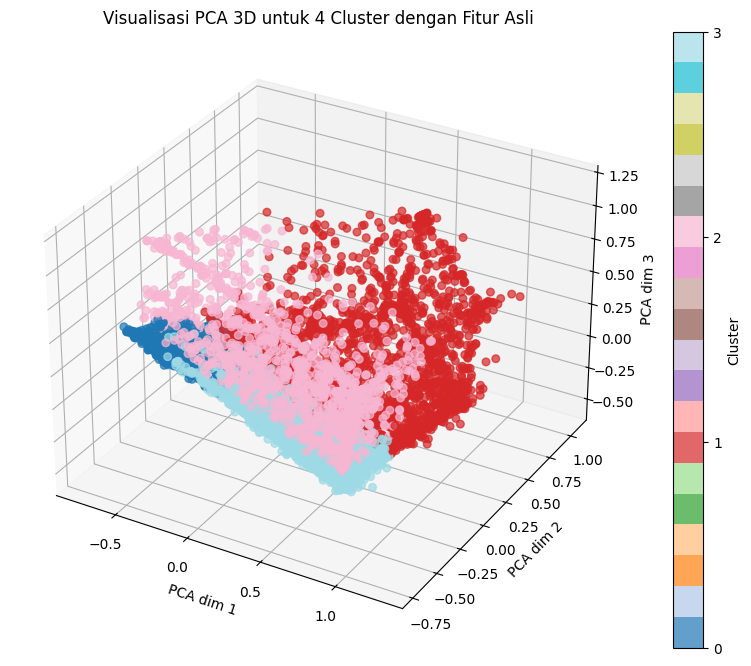

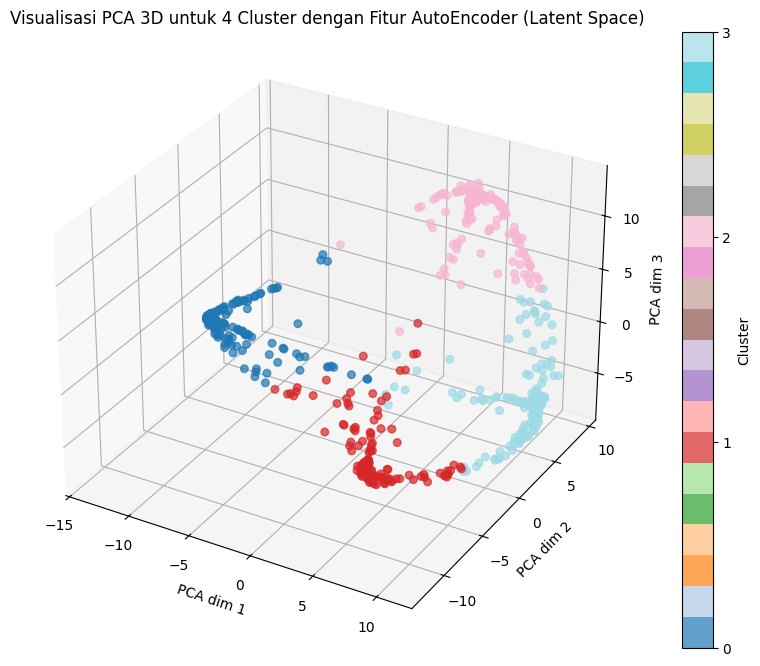

In [20]:
from mpl_toolkits.mplot3d import Axes3D

z_3d = PCA(n_components=3, random_state=42).fit_transform(z.detach().cpu().numpy())
x_3d = PCA(n_components=3, random_state=42).fit_transform(x)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2],
                     c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
ax.set_title(f"Visualisasi PCA 3D untuk {len(np.unique(labels))} Cluster dengan Fitur Asli")
ax.set_xlabel("PCA dim 1")
ax.set_ylabel("PCA dim 2")
ax.set_zlabel("PCA dim 3")
plt.show()
print("")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2],
                     c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
ax.set_title(f"Visualisasi PCA 3D untuk {len(np.chunique(labels))} Cluster dengan Fitur AutoEncoder (Latent Space)")
ax.set_xlabel("PCA dim 1")
ax.set_ylabel("PCA dim 2")
ax.set_zlabel("PCA dim 3")
plt.show()

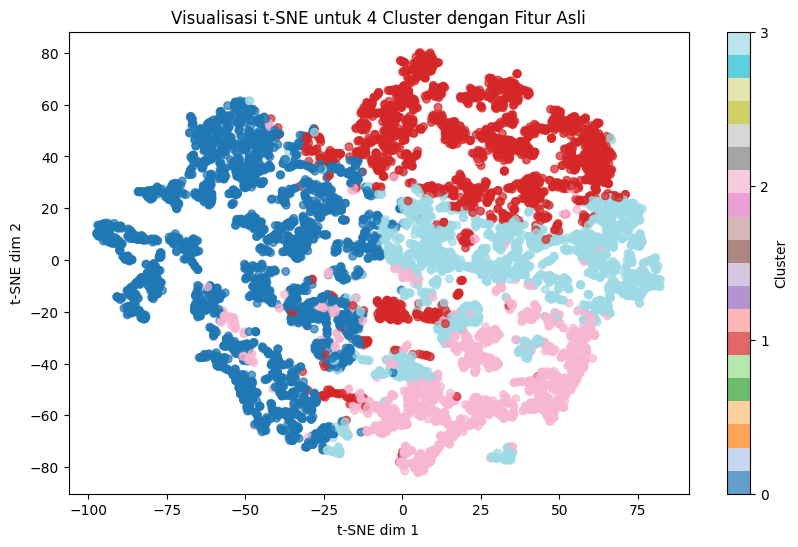

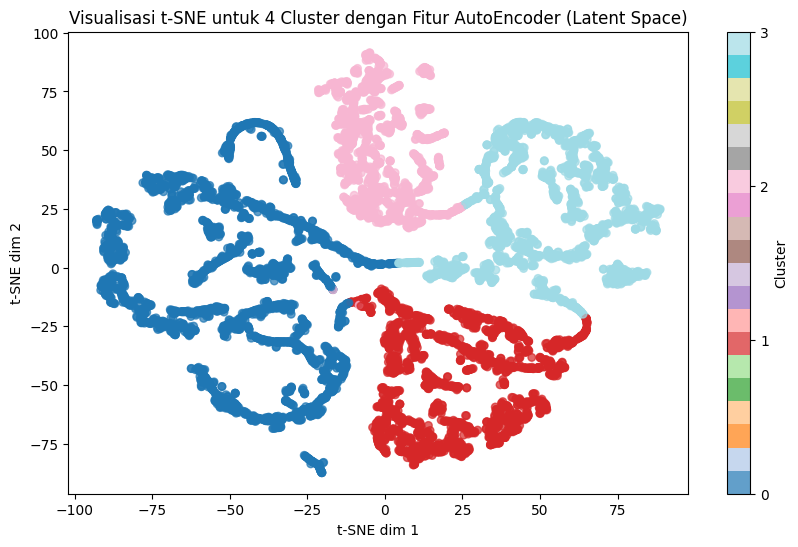

In [21]:
from sklearn.manifold import TSNE

labels = q.argmax(dim=1).detach().cpu().numpy()
z_2d = TSNE(n_components=2, random_state=42).fit_transform(z.detach().cpu().numpy())
x_2d = TSNE(n_components=2, random_state=42).fit_transform(x)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
plt.title(f"Visualisasi t-SNE untuk {len(np.unique(labels))} Cluster dengan Fitur Asli")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()
print("")
plt.figure(figsize=(10, 6))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
plt.title(f"Visualisasi t-SNE untuk {len(np.unique(labels))} Cluster dengan Fitur AutoEncoder (Latent Space)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

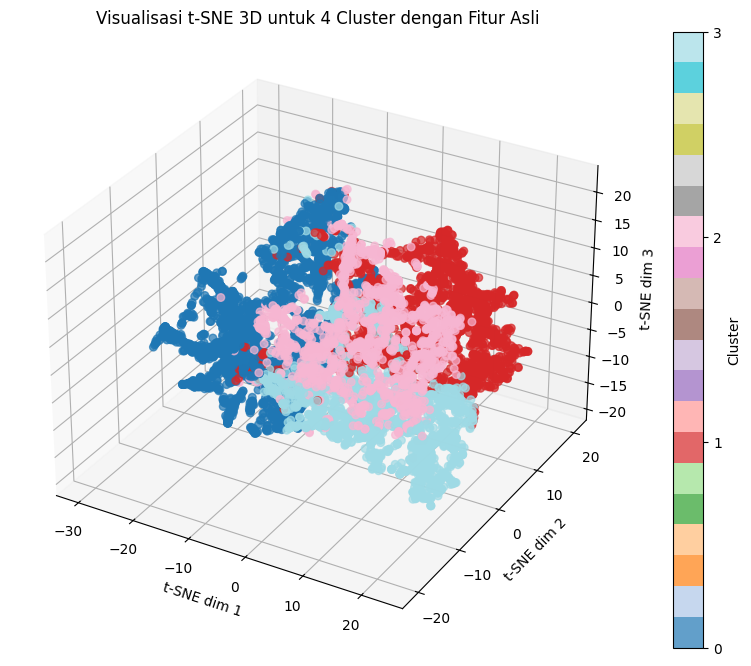

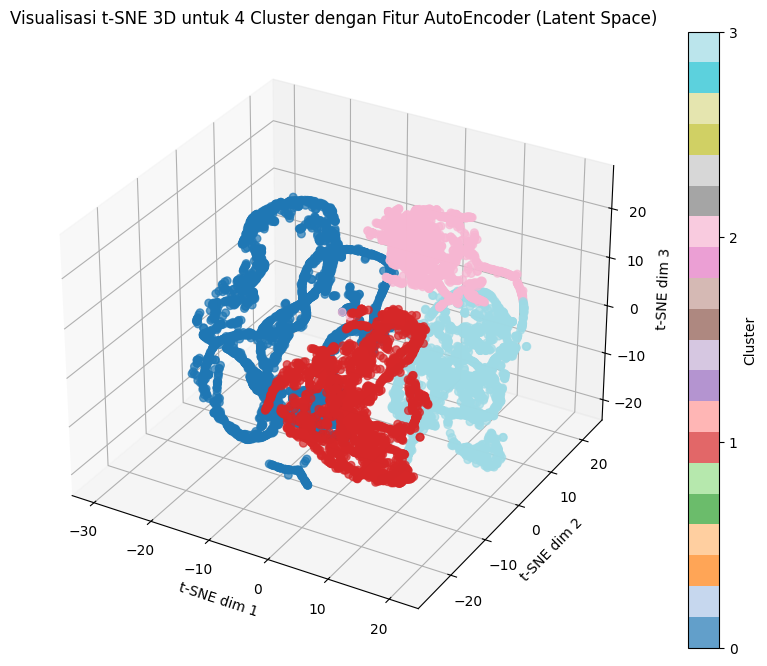

In [22]:
z_3d = TSNE(n_components=3, random_state=42).fit_transform(z.detach().cpu().numpy())
x_3d = TSNE(n_components=3, random_state=42).fit_transform(x)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2],
                     c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
ax.set_title(f"Visualisasi t-SNE 3D untuk {len(np.unique(labels))} Cluster dengan Fitur Asli")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
ax.set_zlabel("t-SNE dim 3")
plt.show()
print("")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2],
                     c=labels, cmap='tab20', alpha=0.7, s=30)
cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(np.unique(labels))))
cbar.set_label('Cluster')
ax.set_title(f"Visualisasi t-SNE 3D untuk {len(np.unique(labels))} Cluster dengan Fitur AutoEncoder (Latent Space)")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
ax.set_zlabel("t-SNE dim 3")
plt.show()